In [1]:
import cv2 as cv
import numpy as np
import math
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('always')


In [2]:
#utils

def openImage(data):
    for i in data:
        cv.imshow(i[1], i[0])
    cv.waitKey(0)
    cv.destroyAllWindows()

def resize(img, scale_percent): 
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    return cv.resize(img, dim, interpolation = cv.INTER_AREA)

In [3]:
#Segmentação
def mapCoffee(img, x, y):
    Y, X = img.shape
    img[y][x]=255
    aux=((x,x),(y,y))
    auxX=(x,x)
    auxY=(y,y)
    for dX in range(-1,2):
        for dY in range(-1,2):
            if y+dY<Y and x+dX<X and img[y+dY][x+dX]==0 and (dX!=0 or dY!=0):
                aux, img = mapCoffee(img, x+dX, y+dY)
                if auxX[0]>aux[0][0]:
                    auxX = (aux[0][0], auxX[1])
                if auxX[1]<aux[0][1]:
                    auxX = (auxX[0], aux[0][1])
                if auxY[0]>aux[1][0]:
                    auxY = (aux[1][0], auxY[1])
                if auxY[1]<aux[1][1]:
                    
                    auxY = (auxY[0], aux[1][1])
    return (auxX, auxY), img


def imgScan(image):
    positons = []
    img = np.copy(image)
    Y,X = image.shape
    y=0
    x=0
    while y<Y:
        if(img[y][x]==0):
            aux, img= mapCoffee(img, x, y)
            positons.append(aux)
        if x==X-1:
            y = y+1
            x = 0
        else:
            x = x+1
    return positons


In [4]:
#Marca grãos

def marcaGraos(img, positions):
    for position in positions:
        cv.rectangle(img, (position[0][0], position[1][0]), (position[0][1], position[1][1]), (255, 0, 0), 2)

In [5]:
#Área e perimetro

def AreaPerimetro(img, x, y):
    area=0
    perimetro=0
    for X in range(x[0], x[1]):
        for Y in range(y[0], y[1]):
            if(img[Y,X]==0):
                area+=1
                if(img[Y+1,X]==255 or img[Y-1, X]==255 or img[Y, X-1]==255 or img[Y, X+1]==255):
                    perimetro+=1
    return area, perimetro




In [6]:
def getHSV(imgL, imgC, x, y):
    hsvImg = cv.cvtColor(imgC, cv.COLOR_RGB2HSV)
    h=0
    s=0
    v=0
    for X in range(x[0], x[1]):
        for Y in range(y[0], y[1]):
            if(imgL[Y,X]==0):
                h+=hsvImg[Y,X,0]
                s+=hsvImg[Y,X,1]
                v+=hsvImg[Y,X,2]
    return h,s,v



In [29]:
def getAtributos(imgFolder, classe, rotate):
    area = 0
    perimetro = 0
    areas = []
    h = 0
    s = 0
    v = 0
    H = []
    S = []
    V = []
    originalPositions = []
    positionsFlag = True
    roundness = []
    classes = []
    realBeans = []

    img = cv.imread(imgFolder, 0)
    imgC = cv.imread(imgFolder, cv.IMREAD_COLOR)
    imgMarcada = cv.imread(imgFolder, cv.IMREAD_COLOR)

    imgMarcada = resize(imgMarcada, 40)

    imgC = resize(imgC, 40)

    resized = resize(img, 40)

    blur = cv.GaussianBlur(resized,(3,3),2)

    thresh = cv.adaptiveThreshold(blur,255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,99,12)


    for i in range(rotate):
        positions = imgScan(thresh)

        for i in positions:
            if(i[0][1]-i[0][0]>10 and i[1][1]-i[1][0]>10):
                realBeans.append(i)
                area, perimetro = AreaPerimetro(thresh, (i[0][0], i[0][1]), (i[1][0], i[1][1]))
                h, s, v = getHSV(thresh,imgC,(i[0][0], i[0][1]), (i[1][0], i[1][1]))
                H.append(h/area)
                S.append(s/area)
                V.append(v/area)
                areas.append(area)
                roundness.append(area*4*math.pi/(perimetro*perimetro))
                classes.append(classe)

        if positionsFlag:
            originalPositions.extend(realBeans)
            positionsFlag = False
        imgC = cv.rotate(imgC, cv.ROTATE_90_CLOCKWISE)
        thresh = cv.rotate(thresh, cv.ROTATE_90_CLOCKWISE)


    print(len(realBeans))
    marcaGraos(imgMarcada, originalPositions)    

    openImage([
        (resized, classe+"_Preto_Branco"), 
        (blur, classe+"_blur"), 
        (thresh, classe+"_Limiarizado"),
        (imgMarcada, classe+"_Marcado")
    ])        

    return areas, roundness, classes, H, S, V, originalPositions





In [8]:
#Analise de dados

def analisaDados(dados):
    bons = {"Area":[], "Roundness": [], "h": [], "s": [], "v": []}
    estragados = {"Area":[], "Roundness": [], "h": [], "s": [], "v": []}
    chocos = {"Area":[], "Roundness": [], "h": [], "s": [], "v": []}

    for index, classe in enumerate(dados['Class']):
        if classe == "bom":
            bons["Area"].append(dados["Area"][index])
            bons["Roundness"].append(dados["Roundness"][index])
            bons["h"].append(dados["h"][index])
            bons["s"].append(dados["s"][index])
            bons["v"].append(dados["v"][index])
        elif classe == "estragado":
            estragados["Area"].append(dados["Area"][index])
            estragados["Roundness"].append(dados["Roundness"][index])
            estragados["h"].append(dados["h"][index])
            estragados["s"].append(dados["s"][index])
            estragados["v"].append(dados["v"][index])
        else:
            chocos["Area"].append(dados["Area"][index])
            chocos["Roundness"].append(dados["Roundness"][index])
            chocos["h"].append(dados["h"][index])
            chocos["s"].append(dados["s"][index])
            chocos["v"].append(dados["v"][index])

    Areas = {"bons":bons["Area"], "estragados":estragados["Area"], "chocos":chocos["Area"]}
    print("Areas:")
    AreasData = pd.DataFrame({ key:pd.Series(value) for key, value in Areas.items() })
    AreasData.plot.box()
    plt.show()

    Roundness = {"bons":bons["Roundness"], "estragados":estragados["Roundness"], "chocos":chocos["Roundness"]}
    print("Roundness:")
    RoundnessData = pd.DataFrame.from_dict({ key:pd.Series(value) for key, value in Roundness.items() })
    RoundnessData.plot.box()
    plt.show()

    h = {"bons":bons["h"], "estragados":estragados["h"], "chocos":chocos["h"]}
    print("Hue:")
    hData = pd.DataFrame({ key:pd.Series(value) for key, value in h.items() })
    hData.plot.box()
    plt.show()

    s = {"bons":bons["s"], "estragados":estragados["s"], "chocos":chocos["s"]}
    print("Saturation:")
    sData = pd.DataFrame.from_dict({ key:pd.Series(value) for key, value in s.items() })
    sData.plot.box()
    plt.show()

    v = {"bons":bons["v"], "estragados":estragados["v"], "chocos":chocos["v"]}
    print("Value:")
    vData = pd.DataFrame.from_dict({ key:pd.Series(value) for key, value in v.items() })
    vData.plot.box()
    plt.show()


In [9]:
def comparaAmostrasPredicao(amostras, predicao):
    data = []
    
    for i in range(len(amostras)):
        data.append([amostras[i], predicao[i]])
    
    head = ["Amostra", "Predição"]
    
    print(tabulate(data, headers=head, tablefmt="grid"))

In [10]:
def imagemEscrita(img, positions, classe):
    fontScale = 0.5
    color = (0, 0, 0)
    thickness = 1
    font = cv.FONT_HERSHEY_SIMPLEX

    for idx, position in enumerate(positions):
        cv.putText(img, classe[idx], (position[0][0], position[1][0]), font, fontScale, color, thickness, cv.LINE_AA)

In [11]:
def imagemClassificada(positions, classe, classificacao):
    posicaoBons = []
    posicaoChocos = []
    posicaoEstragados = []
    classeBons = []
    classeChocos = []
    classeEstragados = []

    bons = cv.imread('./bonsTeste.jpeg', cv.IMREAD_COLOR)
    chocos = cv.imread('./chocosTeste.jpeg', cv.IMREAD_COLOR)
    estragados = cv.imread('./estragadosTeste.jpeg', cv.IMREAD_COLOR)

    bons = resize(bons, 40)
    chocos = resize(chocos, 40)
    estragados = resize(estragados, 40)

    for idx, position in enumerate(positions):
        if classe[idx]=="bom":
            posicaoBons.append(position)
            classeBons.append(classificacao[idx])
        elif classe[idx]=="choco":
            posicaoChocos.append(position)
            classeChocos.append(classificacao[idx])
        else:
            posicaoEstragados.append(position)
            classeEstragados.append(classificacao[idx])

    marcaGraos(bons, posicaoBons) 
    marcaGraos(chocos, posicaoChocos) 
    marcaGraos(estragados, posicaoEstragados)
    imagemEscrita(bons, posicaoBons, classeBons) 
    imagemEscrita(estragados, posicaoEstragados, classeEstragados) 
    imagemEscrita(chocos, posicaoChocos, classeChocos) 

    openImage([
        (bons, "bons"), 
        (chocos, "chocos"), 
        (estragados, "estragados"),
    ])        


Grãos_bons_Treino: 
136
Grãos_estragados_Treino: 
92
Grãos_chocho_Treino: 
128
Areas:


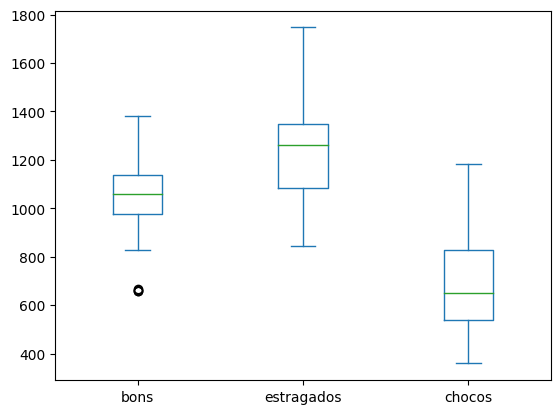

Roundness:


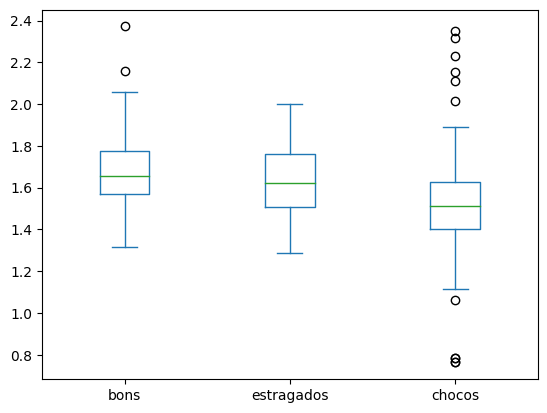

Hue:


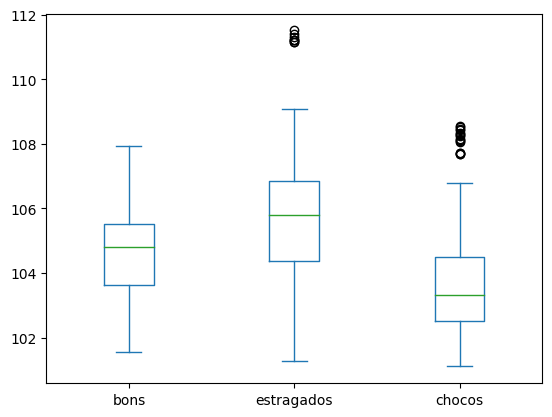

Saturation:


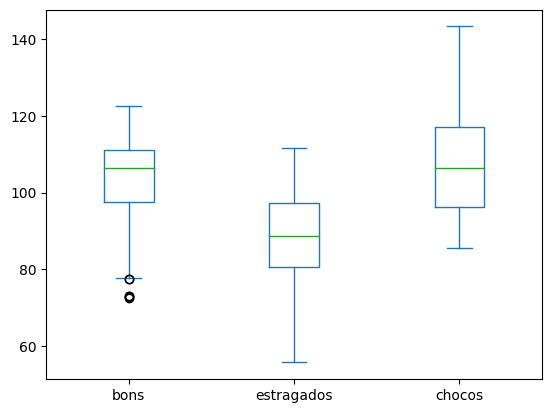

Value:


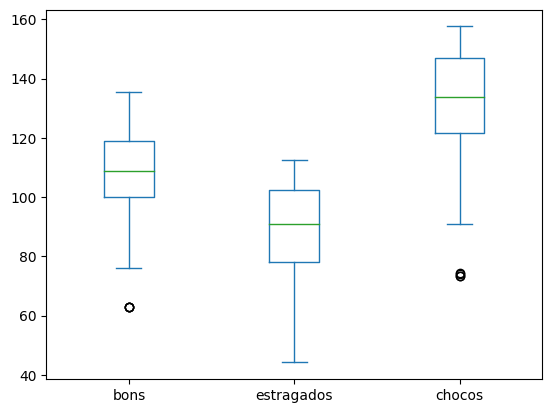

' dataset=pd.DataFrame(data)\ntestDataSet=pd.DataFrame(testData)\n\nX_train= dataset.iloc[:, :-1].values\ny_train= dataset.iloc[:, 5].values\n\nX_test=testDataSet.iloc[:, :-1].values\ny_test= testDataSet.iloc[:, 5].values\n\nscaler = StandardScaler()\nscaler.fit(X_train)\n\nX_train = scaler.transform(X_train)\nX_test = scaler.transform(X_test)\n\nclassifier = KNeighborsClassifier(n_neighbors=10)\nclassifier.fit(X_train, y_train)\n\n\ny_pred = classifier.predict(X_test)\n\ncomparaAmostrasPredicao(y_test, y_pred)\n\nprint(classification_report(y_test, y_pred))\n\nerror = []\n\n# Calculating error for K values between 1 and 40\nfor i in range(1, 40):\n    knn = KNeighborsClassifier(n_neighbors=i)\n    knn.fit(X_train, y_train)\n    pred_i = knn.predict(X_test)\n    error.append(np.mean(pred_i != y_test))\n\nprint("Precision: De todos os grãos classificados como X, N% de fato era X")\nprint("Recall: De todos os grãos que eram do tipo X, N% foram classificados corretamente")\nprint("F1: Méd

In [30]:
areas = []
positions = []
roundness = []
h = []
s = []
v = []
classe = []

print("Grãos_bons_Treino: ")
aux1, aux2, aux3, aux4, aux5, aux6, aux7 = getAtributos('./bons.jpeg',"bom",4)
areas.extend(aux1)
roundness.extend(aux2)
classe.extend(aux3)
h.extend(aux4)
s.extend(aux5)
v.extend(aux6)


print("Grãos_estragados_Treino: ")
aux1, aux2, aux3, aux4, aux5, aux6, aux7 = getAtributos('./estragados.jpeg',"estragado",4)
areas.extend(aux1)
roundness.extend(aux2)
classe.extend(aux3)
h.extend(aux4)
s.extend(aux5)
v.extend(aux6)

print("Grãos_chocho_Treino: ")
aux1, aux2, aux3, aux4, aux5, aux6, aux7 = getAtributos('./chocos.jpeg',"choco",4)
areas.extend(aux1)
roundness.extend(aux2)
classe.extend(aux3)
h.extend(aux4)
s.extend(aux5)
v.extend(aux6)

data={"Area":areas,"Roundness":roundness,"h":h,"s":s,"v":v,"Class":classe}

analisaDados(data)

""" areas = []
roundness = []
classe = []
h = []
s = []
v = []


print("Grãos_bons_Teste: ")
aux1, aux2, aux3, aux4, aux5, aux6, aux7= getAtributos('./bonsTeste.jpeg',"bom")
areas.extend(aux1)
roundness.extend(aux2)
classe.extend(aux3)
h.extend(aux4)
s.extend(aux5)
v.extend(aux6)
positions.extend(aux7)

print("Grãos_Estragado_Teste: ")
aux1, aux2, aux3, aux4, aux5, aux6, aux7= getAtributos('./estragadosTeste.jpeg',"estragado")
areas.extend(aux1)
roundness.extend(aux2)
classe.extend(aux3)
h.extend(aux4)
s.extend(aux5)
v.extend(aux6)
positions.extend(aux7)

print("Grãos_chocos_Teste: ")
aux1, aux2, aux3, aux4, aux5, aux6, aux7= getAtributos('./chocosTeste.jpeg',"choco")
areas.extend(aux1)
roundness.extend(aux2)
classe.extend(aux3)
h.extend(aux4)
s.extend(aux5)
v.extend(aux6)
positions.extend(aux7)

testData={"Area":areas,"Roundness":roundness,"h":h,"s":s,"v":v,"Class":classe} """

""" dataset=pd.DataFrame(data)
testDataSet=pd.DataFrame(testData)

X_train= dataset.iloc[:, :-1].values
y_train= dataset.iloc[:, 5].values

X_test=testDataSet.iloc[:, :-1].values
y_test= testDataSet.iloc[:, 5].values

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(X_train, y_train)


y_pred = classifier.predict(X_test)

comparaAmostrasPredicao(y_test, y_pred)

print(classification_report(y_test, y_pred))

error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

print("Precision: De todos os grãos classificados como X, N% de fato era X")
print("Recall: De todos os grãos que eram do tipo X, N% foram classificados corretamente")
print("F1: Média harmonica entre precision e recall")
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

imagemClassificada(positions, y_test, y_pred) """


Grãos_bons_Treino: 
136
Grãos_estragados_Treino: 
92
Grãos_chocho_Treino: 
128
Grãos_bons_Teste: 
14
Grãos_Estragado_Teste: 
13
Grãos_chocos_Teste: 
14
+-----------+------------+
| Amostra   | Predição   |
+===========+============+
| bom       | bom        |
+-----------+------------+
| bom       | bom        |
+-----------+------------+
| bom       | bom        |
+-----------+------------+
| bom       | bom        |
+-----------+------------+
| bom       | bom        |
+-----------+------------+
| bom       | bom        |
+-----------+------------+
| bom       | bom        |
+-----------+------------+
| bom       | bom        |
+-----------+------------+
| bom       | bom        |
+-----------+------------+
| bom       | bom        |
+-----------+------------+
| bom       | bom        |
+-----------+------------+
| bom       | bom        |
+-----------+------------+
| bom       | bom        |
+-----------+------------+
| bom       | bom        |
+-----------+------------+
| estragado

Text(0, 0.5, 'Mean Error')

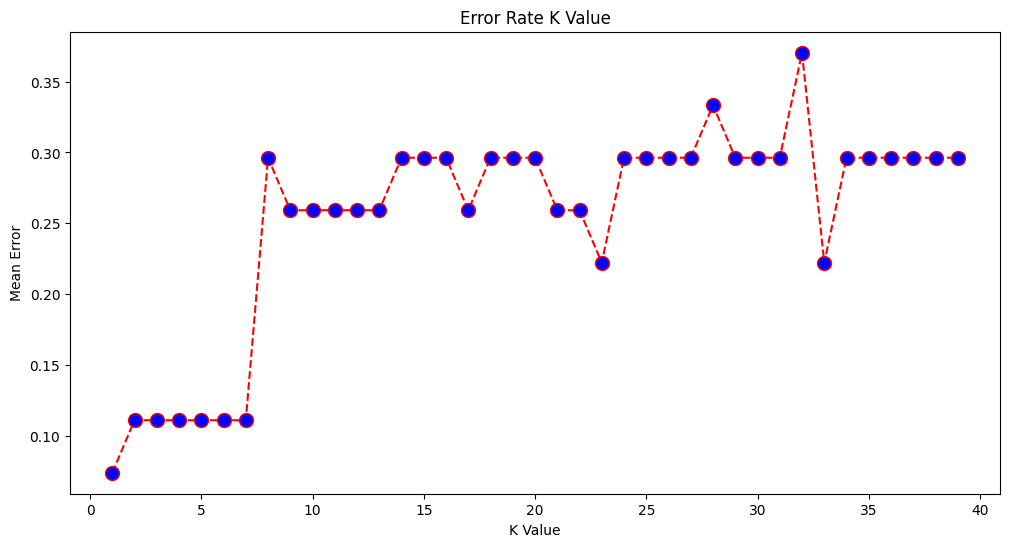

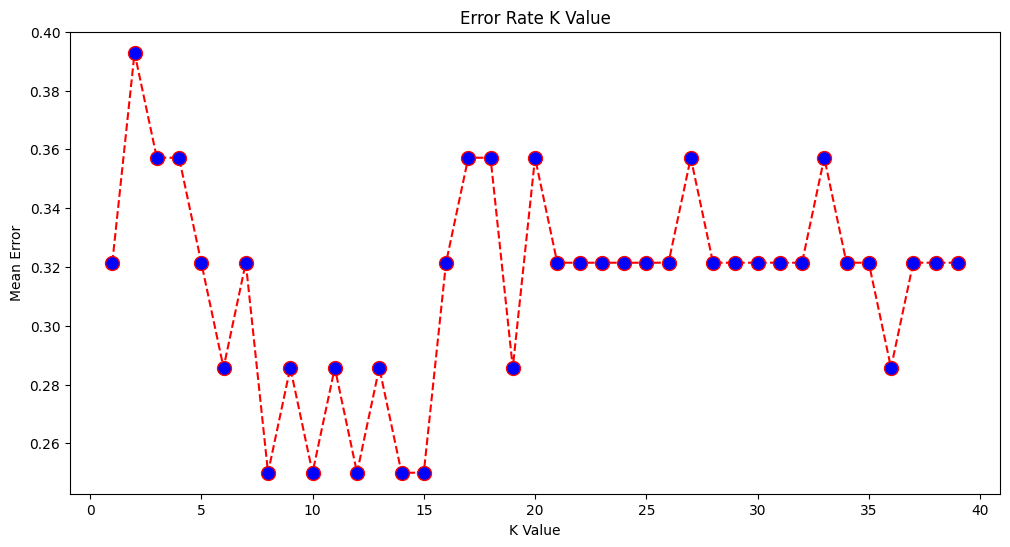

In [31]:

positionsEstragados = []
positionsBons = []
positionsChocos = []
roundnessEstragadosXBons = []
areasEstragadosXBons = []
hEstragadosXBons = []
sEstragadosXBons = []
vEstragadosXBons = []
classeEstragadoXBons = []
classeChocosXBons = []
roundnessChocosXBons = []
areasChocosXBons = []
hChocosXBons = []
sChocosXBons = []
vChocosXBons = []

print("Grãos_bons_Treino: ")
aux1, aux2, aux3, aux4, aux5, aux6, aux7 = getAtributos('./bons.jpeg',"bom",4)
areasEstragadosXBons.extend(aux1)
roundnessEstragadosXBons.extend(aux2)
areasChocosXBons.extend(aux1)
roundnessChocosXBons.extend(aux2)
classeEstragadoXBons.extend(aux3)
classeChocosXBons.extend(aux3)
hChocosXBons.extend(aux4)
sChocosXBons.extend(aux5)
vChocosXBons.extend(aux6)
hEstragadosXBons.extend(aux4)
sEstragadosXBons.extend(aux5)
vEstragadosXBons.extend(aux6)


print("Grãos_estragados_Treino: ")
aux1, aux2, aux3, aux4, aux5, aux6, aux7 = getAtributos('./estragados.jpeg',"estragado",4)
areasEstragadosXBons.extend(aux1)
roundnessEstragadosXBons.extend(aux2)
classeEstragadoXBons.extend(aux3)
hEstragadosXBons.extend(aux4)
sEstragadosXBons.extend(aux5)
vEstragadosXBons.extend(aux6)

print("Grãos_chocho_Treino: ")
aux1, aux2, aux3, aux4, aux5, aux6, aux7 = getAtributos('./chocos.jpeg',"choco",4)
areasChocosXBons.extend(aux1)
roundnessChocosXBons.extend(aux2)
classeChocosXBons.extend(aux3)
hChocosXBons.extend(aux4)
sChocosXBons.extend(aux5)
vChocosXBons.extend(aux6)

dataChocosXBons={"h":hChocosXBons,"s":sChocosXBons,"v":vChocosXBons,"Area":areasChocosXBons,"Roundness":roundnessChocosXBons,"Class":classeChocosXBons}
#dataChocosXBons={"v":vChocosXBons,"Area":areasChocosXBons,"Roundness":roundnessChocosXBons,"Class":classeChocosXBons}
dataEstragadosXBons={"h":hEstragadosXBons,"s":sEstragadosXBons,"v":vEstragadosXBons,"Area":areasEstragadosXBons,"Roundness":roundnessEstragadosXBons,"Class":classeEstragadoXBons}

roundnessEstragadosXBons = []
areasEstragadosXBons = []
hEstragadosXBons = []
sEstragadosXBons = []
vEstragadosXBons = []
roundnessChocosXBons = []
areasChocosXBons = []
hChocosXBons = []
sChocosXBons = []
vChocosXBons = []
classeEstragadoXBons = []
classeChocosXBons = []

print("Grãos_bons_Teste: ")
aux1, aux2, aux3, aux4, aux5, aux6, aux7= getAtributos('./bonsTeste.jpeg',"bom",1)
areasEstragadosXBons.extend(aux1)
roundnessEstragadosXBons.extend(aux2)
areasChocosXBons.extend(aux1)
roundnessChocosXBons.extend(aux2)
classeEstragadoXBons.extend(aux3)
classeChocosXBons.extend(aux3)
hChocosXBons.extend(aux4)
sChocosXBons.extend(aux5)
vChocosXBons.extend(aux6)
hEstragadosXBons.extend(aux4)
sEstragadosXBons.extend(aux5)
vEstragadosXBons.extend(aux6)
positionsBons.extend(aux7)

print("Grãos_Estragado_Teste: ")
aux1, aux2, aux3, aux4, aux5, aux6, aux7= getAtributos('./estragadosTeste.jpeg',"estragado",1)
areasEstragadosXBons.extend(aux1)
roundnessEstragadosXBons.extend(aux2)
classeEstragadoXBons.extend(aux3)
hEstragadosXBons.extend(aux4)
sEstragadosXBons.extend(aux5)
vEstragadosXBons.extend(aux6)
positionsEstragados.extend(aux7)

print("Grãos_chocos_Teste: ")
aux1, aux2, aux3, aux4, aux5, aux6, aux7= getAtributos('./chocosTeste.jpeg',"choco",1)
areasChocosXBons.extend(aux1)
roundnessChocosXBons.extend(aux2)
classeChocosXBons.extend(aux3)
hChocosXBons.extend(aux4)
sChocosXBons.extend(aux5)
vChocosXBons.extend(aux6)
positionsChocos.extend(aux7)

testDataChocosXBons={"h":hChocosXBons,"s":sChocosXBons,"v":vChocosXBons,"Area":areasChocosXBons,"Roundness":roundnessChocosXBons,"Class":classeChocosXBons}
#testDataChocosXBons={"v":vChocosXBons,"Area":areasChocosXBons,"Roundness":roundnessChocosXBons,"Class":classeChocosXBons}
testDataEstragadosXBons={"h":hEstragadosXBons,"s":sEstragadosXBons,"v":vEstragadosXBons,"Area":areasEstragadosXBons,"Roundness":roundnessEstragadosXBons,"Class":classeEstragadoXBons}

#Classifica Estragados

dataset=pd.DataFrame(dataEstragadosXBons)
testDataSet=pd.DataFrame(testDataEstragadosXBons)

X_train= dataset.iloc[:, :-1].values
y_train= dataset.iloc[:, 5].values

X_test=testDataSet.iloc[:, :-1].values
y_test= testDataSet.iloc[:, 5].values

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(X_train, y_train)


y_pred = classifier.predict(X_test)

comparaAmostrasPredicao(y_test, y_pred)

print(classification_report(y_test, y_pred))

error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

print("Precision: De todos os grãos classificados como X, N% de fato era X")
print("Recall: De todos os grãos que eram do tipo X, N% foram classificados corretamente")
print("F1: Média harmonica entre precision e recall")
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

#Classifica Chocos

dataset=pd.DataFrame(dataChocosXBons)
testDataSet=pd.DataFrame(testDataChocosXBons)

X_train= dataset.iloc[:, :-1].values
y_train= dataset.iloc[:, 3].values

X_test=testDataSet.iloc[:, :-1].values
y_test= testDataSet.iloc[:, 3].values

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=15)
classifier.fit(X_train, y_train)


y_pred = classifier.predict(X_test)

comparaAmostrasPredicao(y_test, y_pred)

print(classification_report(y_test, y_pred))

error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

print("Precision: De todos os grãos classificados como X, N% de fato era X")
print("Recall: De todos os grãos que eram do tipo X, N% foram classificados corretamente")
print("F1: Média harmonica entre precision e recall")
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')



#imagemClassificada(positions, y_test, y_pred)